<a href="https://colab.research.google.com/github/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/blob/main/THOMAS_MVP_SPRINT_3_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP Machine Learning & Analytics**<br>
<hr>
Versão: 1.0

**Nome:** Thomas Alves de Souza Abrantes  
**Matrícula:** 4052025000680 (RA)

**Dataset:** Datasets extraídos do Portal Dados Abertos do Governo Federal.  

*  **Fonte dos dados:** https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira
*  O link abre os Arquivos disponibilizados pelo CENIPA, contendo informações das ocorrências aeronáuticas na aviação Civil Brasileira, separados em 5 arquivos.  
*  Os arquivos possuem informações sobre:
  *  Aeronaves
  *  Dados da ocorrência
  *  Tipo de ocorrência
  *  Fator contribuinte
  *  Recomendações
  
Os dados em cada arquivo serão analisados com mais detalhes após a carga.  
A imagem abaixo ilustra o modelo de dados dos arquivos (datasets).

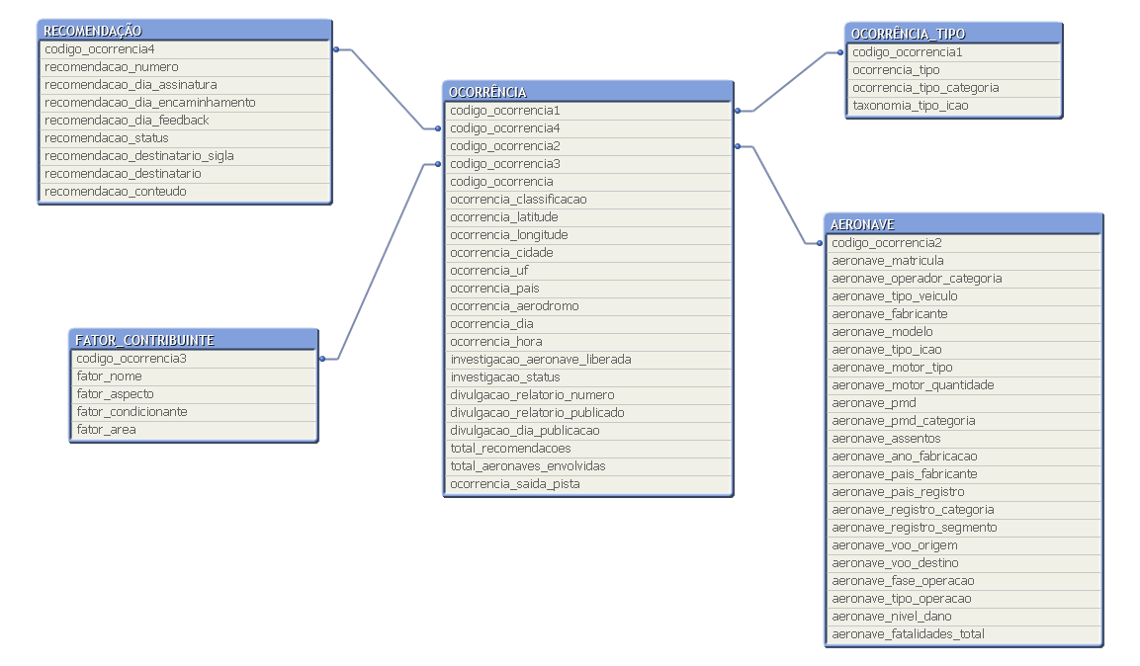

#**Configuração do notebook**

##Bibliotecas

Instalações necessárias:
*  **XGBoost:** Biblioteca de código aberto e um algoritmo de machine learning que implementa a técnica de gradient boosting para resolver problemas de regressão e classificação, especialmente em dados tabulares.
*  **imbalanced-learn:** Biblioteca Python de código aberto projetada para ajudar a resolver problemas de desequilíbrio de classes em aprendizado de máquina. A biblioteca fornece ferramentas e algoritmos para processar conjuntos de dados desbalanceados e melhorar o desempenho do modelo.

In [1]:
!pip install xgboost
!pip install imbalanced-learn

Importações

In [2]:
# Bibliotecas do notebook
import joblib
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb

# Omite warning de deprecated no pandas
warnings.filterwarnings('ignore', category=DeprecationWarning, module='pandas')

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from google.colab import files

##Variáveis globais

In [3]:
# URLs dos arquivos raw no repositório do GitHub
URL_AERONAVES = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/aeronave.csv'
URL_OCORRENCIA = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia.csv'
URL_OCORRENCIA_TIPO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia_tipo.csv'
URL_FATOR_CONTRIBUINTE = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/fator_contribuinte.csv'
URL_RECOMENDACAO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/recomendacao.csv'

#Mensagens
MSG_DATAFRAME_LIMPO_SUFIX = 'sem valores Nulos'
MSG_LISTA_VALORES_COLUNA = 'Lista de todos os valores da coluna'
MSG_A_PREVISAO_DO_MODELO_E = 'A previsão para o novo dado é:'
MSG_TOTAL_REGISTROS = 'Total de registros'
MSG_TOTAL_COLUNAS = 'Total de colunas'
MSG_DADOS_NULOS_POR_COLUNA = 'Dados de Nulos por Coluna'

#Dataframes
DATAFRAME_CONSOLIDADO = 'Dataframe Consolidado'
DATAFRAME_AERONAVES = 'Dataframe Aeronaves'
DATAFRAME_OCORRENCIAS = 'Dataframe Ocorrências'
DATAFRAME_TIPO_OCORRENCIA = 'Dataframe Tipo de Ocorrência'
DATAFRAME_FATOR_CONTRIBUINTE = 'Dataframe Fator Contribuinte'
DATAFRAME_RECOMENDACAO = 'Dataframe Recomendação'
DATAFRAME_AERONAVES_SEM_NULOS = DATAFRAME_AERONAVES + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_OCORRENCIAS_SEM_NULOS = DATAFRAME_OCORRENCIAS + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_TIPO_OCORRENCIAS_SEM_NULOS = DATAFRAME_TIPO_OCORRENCIA + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_RECOMENDACAO_SEM_NULOS = DATAFRAME_RECOMENDACAO + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS = DATAFRAME_FATOR_CONTRIBUINTE + ' ' + MSG_DATAFRAME_LIMPO_SUFIX

# Coluna
COLUNA_PERCENTUAL_DE_VALORES_NULOS = 'percentual de valores nulos'

# Outros
ENCODING_LATIN = 'latin1'
SEPARADOS_CSV = ';'
ON_BAD_LINES_SKIP = 'skip'

##Funções

In [4]:
#Imprime linhas pontilhadas para separação de mensagens
def separadorLinha(adicionarMaisUmaLinhaVazia = False):
  print("-" * 100)
  if (adicionarMaisUmaLinhaVazia is True):
      print("\n")

def analisar_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analisa e retorna um DataFrame com a contagem e o percentual
    de valores nulos de cada coluna.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Returns:
        pd.DataFrame: Um novo DataFrame com as colunas 'coluna', 'nulos'
                      e 'percentual de valores nulos'.
    """

    # Conta a quantidade de valores nulos em cada coluna
    nulos_por_coluna = df.isnull().sum()

    # Filtra apenas as colunas com valores nulos
    colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

    # Se não houver colunas com nulos, retorna um DataFrame vazio
    if colunas_com_nulos.empty:
        return pd.DataFrame(columns=['coluna', 'nulos', 'percentual de valores nulos'])

    # Calcula o percentual de nulos
    total_registros = len(df)
    percentual_nulos = (colunas_com_nulos / total_registros) * 100

    # Cria o DataFrame final com os resultados
    df_nulos = pd.DataFrame({
        'coluna': colunas_com_nulos.index,
        'nulos': colunas_com_nulos.values,
        'percentual de valores nulos': percentual_nulos.values
    })

    # Arredonda o percentual para duas casas decimais
    df_nulos['percentual de valores nulos'] = df_nulos['percentual de valores nulos'].round(2)

    return df_nulos


#**Carga dos Dados**

In [5]:
# Carregando os dataFrames
df_aeronaves = pd.read_csv(URL_AERONAVES, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencias = pd.read_csv(URL_OCORRENCIA, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencia_tipo = pd.read_csv(URL_OCORRENCIA_TIPO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_fator_contribuinte = pd.read_csv(URL_FATOR_CONTRIBUINTE, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_recomendacao = pd.read_csv(URL_RECOMENDACAO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)

# Exibindo as primeiras linhas para confirmar o carregamento
print(DATAFRAME_AERONAVES)
separadorLinha()
print(df_aeronaves.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(df_ocorrencias.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(df_ocorrencia_tipo.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(df_recomendacao.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.head().to_string(index=False))
separadorLinha(True)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
 codigo_ocorrencia2 aeronave_matricula aeronave_operador_categoria aeronave_tipo_veiculo                    aeronave_fabricante   aeronave_modelo aeronave_tipo_icao aeronave_motor_tipo aeronave_motor_quantidade  aeronave_pmd  aeronave_pmd_categoria  aeronave_assentos  aeronave_ano_fabricacao aeronave_pais_fabricante aeronave_pais_registro aeronave_registro_categoria aeronave_registro_segmento                     aeronave_voo_origem            aeronave_voo_destino aeronave_fase_operacao aeronave_tipo_operacao aeronave_nivel_dano  aeronave_fatalidades_total
              87125              PSAEX                         ***                 AVIÃO                                EMBRAER       ERJ 190-400               E295                 NaN                       ***       61200.0                 61200.0                0.0                   2024.0                   BRASIL

#**Avaliando cada dataframe criado com os dados carregados**

###Dataframe Aeronaves

Estrutura

In [6]:
print(DATAFRAME_AERONAVES)
separadorLinha()
df_aeronaves.info()

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13301 entries, 0 to 13300
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codigo_ocorrencia2           13301 non-null  int64  
 1   aeronave_matricula           13300 non-null  object 
 2   aeronave_operador_categoria  13292 non-null  object 
 3   aeronave_tipo_veiculo        13300 non-null  object 
 4   aeronave_fabricante          13296 non-null  object 
 5   aeronave_modelo              13291 non-null  object 
 6   aeronave_tipo_icao           13290 non-null  object 
 7   aeronave_motor_tipo          12828 non-null  object 
 8   aeronave_motor_quantidade    13300 non-null  object 
 9   aeronave_pmd                 13300 non-null  float64
 10  aeronave_pmd_categoria       13300 non-null  float64
 11  aeronave_as

Listando as primeiras linhas do df_aeronaves.


In [7]:
df_aeronaves.head()

,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,...,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,87125,PSAEX,***,AVIÃO,EMBRAER,ERJ 190-400,E295,NaN,***,61200.0,...,BRASIL,BRASIL,AVIÃO,***,VIRACOPOS,ORLANDO BEZERRA DE MENEZES,DESCIDA,REGULAR,NENHUM,0.0
1,87124,PRYXD,***,AVIÃO,ATR - GIE AVIONS DE TRANSPORT RÉGIONAL,ATR-72-212A (600),AT76,***,***,23000.0,...,BRASIL,BRASIL,AVIÃO,***,TENENTE-CORONEL AVIADOR CÉSAR BOMBONATO,TANCREDO NEVES,SUBIDA,REGULAR,NENHUM,0.0
2,87123,PRXBT,***,***,AIRBUS S.A.S.,A320-271N,A20N,NaN,BIMOTOR,79000.0,...,BRASIL,BRASIL,***,***,GOVERNADOR ANDRÉ FRANCO MONTORO,PINTO MARTINS,DECOLAGEM,REGULAR,NENHUM,0.0
3,87122,PRAKJ,***,AVIÃO,ATR - GIE AVIONS DE TRANSPORT RÉGIONAL,ATR-72-212A (600),AT76,TURBOÉLICE,BIMOTOR,22000.0,...,BRASIL,BRASIL,AVIÃO,***,SANTA MARIA,VIRACOPOS,DECOLAGEM,REGULAR,NENHUM,0.0
4,87121,PRMHK,***,AVIÃO,AIRBUS,A320-214,A320,JATO,BIMOTOR,77000.0,...,BRASIL,BRASIL,AVIÃO,***,PROFESSOR ERIBERTO MANOEL REINO,GOVERNADOR ANDRÉ FRANCO MONTORO,DECOLAGEM,REGULAR,LEVE,0.0


###Dataframe Ocorrências

Estrutura

In [8]:
print(DATAFRAME_OCORRENCIAS)
separadorLinha()
df_ocorrencias.info()

Dataframe Ocorrências
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13185 entries, 0 to 13184
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   codigo_ocorrencia               13185 non-null  int64 
 1   codigo_ocorrencia1              13185 non-null  int64 
 2   codigo_ocorrencia2              13185 non-null  int64 
 3   codigo_ocorrencia3              13185 non-null  int64 
 4   codigo_ocorrencia4              13185 non-null  int64 
 5   ocorrencia_classificacao        13185 non-null  object
 6   ocorrencia_latitude             10425 non-null  object
 7   ocorrencia_longitude            10425 non-null  object
 8   ocorrencia_cidade               13185 non-null  object
 9   ocorrencia_uf                   13185 non-null  object
 10  ocorrencia_pais                 13185 non-n

Listando as primeiras linhas df_ocorrencias

In [9]:
df_ocorrencias.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
0,87125,87125,87125,87125,87125,INCIDENTE,-7.219166666666,-39.26944444444,JUAZEIRO DO NORTE,CE,...,11/05/2025,04:20:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1,87124,87124,87124,87124,87124,INCIDENTE,-18.88361111111,-48.22527777777,UBERLÂNDIA,MG,...,08/05/2025,14:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
2,87123,87123,87123,87123,87123,INCIDENTE,-23.43555555555,-46.47305555555,GUARULHOS,SP,...,09/05/2025,18:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
3,87122,87122,87122,87122,87122,INCIDENTE,-29.71083333333,-53.69222222222,SANTA MARIA,RS,...,04/05/2025,14:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
4,87121,87121,87121,87121,87121,INCIDENTE,-20.81722222222,-49.40694444444,SÃO JOSÉ DO RIO PRETO,SP,...,10/05/2025,10:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


###DataFrame Tipo de Ocorrência

Estrutura

In [10]:
print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
df_ocorrencia_tipo.info()

Dataframe Tipo de Ocorrência
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13900 entries, 0 to 13899
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   codigo_ocorrencia1         13900 non-null  int64 
 1   ocorrencia_tipo            13895 non-null  object
 2   ocorrencia_tipo_categoria  13895 non-null  object
 3   taxonomia_tipo_icao        13895 non-null  object
dtypes: int64(1), object(3)
memory usage: 434.5+ KB


Listando as primeiras linhas df_ocorrencia_tipo

In [11]:
df_ocorrencia_tipo.head()

,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,87125,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
1,87124,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
2,87123,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
3,87122,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
4,87121,COLISÃO COM AVE,COLISÃO COM AVE,BIRD


##Dataframe Fator Contribuinte

Estrutura

In [12]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
df_fator_contribuinte.info()

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8613 entries, 0 to 8612
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   codigo_ocorrencia3   8613 non-null   int64 
 1   fator_nome           8613 non-null   object
 2   fator_aspecto        8613 non-null   object
 3   fator_condicionante  8613 non-null   object
 4   fator_area           8613 non-null   object
dtypes: int64(1), object(4)
memory usage: 336.6+ KB


Listando as primeiras linhas df_fator_contribuinte

In [13]:
df_fator_contribuinte.head()

,codigo_ocorrencia3,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,85239,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,85239,ATITUDE,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
2,85239,CONDIÇÕES METEOROLÓGICAS ADVERSAS,ELEMENTOS RELACIONADOS AO AMBIENTE OPERACIONAL,***,FATOR OPERACIONAL
3,85239,PERCEPÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
4,85239,PROCESSO DECISÓRIO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO


##Dataframe Recomendação

Estrutura

In [14]:
print(DATAFRAME_RECOMENDACAO)
separadorLinha()
df_recomendacao.info()

Dataframe Recomendação
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   codigo_ocorrencia4               3387 non-null   object
 1   recomendacao_numero              2890 non-null   object
 2   recomendacao_dia_assinatura      2890 non-null   object
 3   recomendacao_dia_encaminhamento  2890 non-null   object
 4   recomendacao_dia_feedback        2217 non-null   object
 5   recomendacao_conteudo            2889 non-null   object
 6   recomendacao_status              2889 non-null   object
 7   recomendacao_destinatario_sigla  2889 non-null   object
 8   recomendacao_destinatario        2889 non-null   object
dtypes: object(9)
memory usage: 238.3+ KB


Listando as primeiras linhas df_recomendacao

In [15]:
df_recomendacao.head()

,codigo_ocorrencia4,recomendacao_numero,recomendacao_dia_assinatura,recomendacao_dia_encaminhamento,recomendacao_dia_feedback,recomendacao_conteudo,recomendacao_status,recomendacao_destinatario_sigla,recomendacao_destinatario
0,84857,A-092/CENIPA/2024 - 01,2025-04-22,2025-04-23,NaN,Divulgar os ensinamentos colhidos na presente ...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
1,83193,A-014/CENIPA/2024 - 01,2025-02-17,2025-02-19,NaN,Divulgar os ensinamentos colhidos na presente ...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
2,83193,A-014/CENIPA/2024 - 02,2025-02-17,2025-02-19,2025-03-07,Divulgar os ensinamentos colhidos na presente ...,ADOTADA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
3,82458,A-146/CENIPA/2023 - 01,2025-03-13,2025-04-08,2025-05-09,Divulgar os ensinamentos colhidos na presente ...,ADOTADA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
4,82458,A-146/CENIPA/2023 - 02,2025-03-13,2025-04-08,NaN,Avaliar a pertinência de revisar os requisitos...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL


#**Consultando valores nulos**

##Dataframe Aeronaves

Avaliando a necessidade de remover ou normalizar valores inválidos em cada dataframe.

In [16]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                         coluna  nulos  percentual de valores nulos
0            aeronave_matricula      1                         0.01
1   aeronave_operador_categoria      9                         0.07
2         aeronave_tipo_veiculo      1                         0.01
3           aeronave_fabricante      5                         0.04
4               aeronave_modelo     10                         0.08
5            aeronave_tipo_icao     11                         0.08
6           aeronave_motor_tipo    473                         3.56
7     aeronave_motor_quantidade      1                         0.01
8                  aeronave_pmd      1                         0.01
9        aeronave_pmd_categoria      1                         0.01
10  

Em **df_aeronaves** a maior quantidade de valores nulos consta no "numero de assentos", "tipo de motor" e "ano de fabricação".  
Nenhuma informação na documentação informa se a falta de valores no campo tipo de motor e ano de fabricação, indica um valor padrão.  

**Observação:** A ausência de assentos é viável para casos de aviões de cargas, por este motivo, não será considerada na remoção de nulos e estes valores serão atualizados com valor zero de assentos.

In [17]:
# Preenchendo valores da coluna 'aeronave_assentos' com valor zero
df_aeronaves['aeronave_assentos'] = df_aeronaves['aeronave_assentos'].fillna(0)

Gerando uma nova consulta de valores nulos.

In [18]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                         coluna  nulos  percentual de valores nulos
0            aeronave_matricula      1                         0.01
1   aeronave_operador_categoria      9                         0.07
2         aeronave_tipo_veiculo      1                         0.01
3           aeronave_fabricante      5                         0.04
4               aeronave_modelo     10                         0.08
5            aeronave_tipo_icao     11                         0.08
6           aeronave_motor_tipo    473                         3.56
7     aeronave_motor_quantidade      1                         0.01
8                  aeronave_pmd      1                         0.01
9        aeronave_pmd_categoria      1                         0.01
10  

As colunas com a informação do "tipo de motor" e "ano de fabricação" representam menos de 8% de toda a massa de dados e serão removidas posteriormente.

##Dataframe Tipo de Ocorrência

In [19]:
df_nulos = analisar_nulos(df_ocorrencia_tipo)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Tipo de Ocorrência
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                      coluna  nulos  percentual de valores nulos
0            ocorrencia_tipo      5                         0.04
1  ocorrencia_tipo_categoria      5                         0.04
2        taxonomia_tipo_icao      5                         0.04


Como podemos ver, a quantidade de valores nulos pode ser desconsideradas por representar menos de 0,5% de toda a massa de dados.

##Dataframe Ocorrências

In [20]:
df_nulos = analisar_nulos(df_ocorrencias)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Ocorrências
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                        coluna  nulos  percentual de valores nulos
0          ocorrencia_latitude   2760                        20.93
1         ocorrencia_longitude   2760                        20.93
2              ocorrencia_hora      2                         0.02
3          investigacao_status      1                         0.01
4  divulgacao_relatorio_numero    643                         4.88
5    divulgacao_dia_publicacao  10677                        80.98


Neste dataframe temos uma proporção alta de valores nulos, mas até o momento, as colunas com esses resultados não serão importantes para a predição.

##Dataframe Recomendação

In [21]:
df_nulos = analisar_nulos(df_recomendacao)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Recomendação
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                            coluna  nulos  percentual de valores nulos
0               codigo_ocorrencia4      1                         0.03
1              recomendacao_numero    498                        14.70
2      recomendacao_dia_assinatura    498                        14.70
3  recomendacao_dia_encaminhamento    498                        14.70
4        recomendacao_dia_feedback   1171                        34.56
5            recomendacao_conteudo    499                        14.73
6              recomendacao_status    499                        14.73
7  recomendacao_destinatario_sigla    499                        14.73
8        recomendacao_destinatario    499                        14.73


O dataframe com as recomendações, tem colunas com mais de 10% dos registros com informações nulas.  
Caso seja fundamental o seu uso, será analisado posteriormente.

##Dataframe Fator Contribuinte

In [22]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.isnull().sum())

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
codigo_ocorrencia3     0
fator_nome             0
fator_aspecto          0
fator_condicionante    0
fator_area             0
dtype: int64


Nenhum valor nulo encontrado, verificando se o dataframe possui registros.

In [23]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(f'Total de registros: {len(df_fator_contribuinte)}')

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
Total de registros: 8613


#**Limpeza dos valores nulos**

###Dataframe Aeronaves

In [24]:
colunas_do_dataframe = list(df_aeronaves.columns)

df_aeronaves_limpo = df_aeronaves.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_aeronaves.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_aeronaves_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_AERONAVES_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_aeronaves_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13301, 23)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (12050, 23)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Aeronaves sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia2             0
aeronave_matricula             0
aeronave_operador_categoria    0
aeronave_tipo_veiculo          0
aeronave_fabricante            0
aeronave_modelo                0
aeronave_tipo_icao             0
aeronave_motor_tipo            0
aeronave_motor_quantidade      0
aeronave_pmd                   0
aeronave_pmd_categoria         0
aeronave_assentos              0
aeronave_ano_fabricacao        0
aeronave_pai

###Dataframe Ocorrências

In [25]:
colunas_do_dataframe = list(df_ocorrencias.columns)

df_ocorrencias_limpo = df_ocorrencias.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencias.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencias_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencias_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13185, 22)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (2499, 22)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Ocorrências sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia                 0
codigo_ocorrencia1                0
codigo_ocorrencia2                0
codigo_ocorrencia3                0
codigo_ocorrencia4                0
ocorrencia_classificacao          0
ocorrencia_latitude               0
ocorrencia_longitude              0
ocorrencia_cidade                 0
ocorrencia_uf                     0
ocorrencia_pais                   0
ocorrencia_aerodromo              0
ocorrenc

###Dataframe Tipo de Ocorrência

In [26]:
colunas_do_dataframe = list(df_ocorrencia_tipo.columns)

df_ocorrencia_tipo_limpo = df_ocorrencia_tipo.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencia_tipo.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencia_tipo_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencia_tipo_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13900, 4)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (13895, 4)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Ocorrências sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia1           0
ocorrencia_tipo              0
ocorrencia_tipo_categoria    0
taxonomia_tipo_icao          0
dtype: int64


###Dataframe Recomendação

In [27]:
colunas_do_dataframe = list(df_recomendacao.columns)

df_recomendacao_limpo = df_recomendacao.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_recomendacao.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_recomendacao_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_RECOMENDACAO_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_recomendacao_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (3388, 9)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (2217, 9)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Recomendação sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia4                 0
recomendacao_numero                0
recomendacao_dia_assinatura        0
recomendacao_dia_encaminhamento    0
recomendacao_dia_feedback          0
recomendacao_conteudo              0
recomendacao_status                0
recomendacao_destinatario_sigla    0
recomendacao_destinatario          0
dtype: int64


###Dataframe Fator Contribuinte

In [28]:
colunas_do_dataframe = list(df_fator_contribuinte.columns)

df_fator_contribuinte_limpo = df_fator_contribuinte.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_fator_contribuinte.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_fator_contribuinte_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_fator_contribuinte_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (8613, 5)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (8613, 5)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Fator Contribuinte sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia3     0
fator_nome             0
fator_aspecto          0
fator_condicionante    0
fator_area             0
dtype: int64


#**Consolidado os dataframes**

Com os dataframes "limpos", vamos consolidar em um único dataframe para realizar o treino.

In [29]:
# Unindo os dataframes
df_consolidado = pd.merge(df_ocorrencias_limpo, df_aeronaves_limpo, on='codigo_ocorrencia2', how='left')
df_consolidado = pd.merge(df_consolidado, df_ocorrencia_tipo_limpo, on='codigo_ocorrencia1', how='left')
df_consolidado = pd.merge(df_consolidado, df_fator_contribuinte_limpo, on='codigo_ocorrencia3', how='left')

# Convertendo a coluna 'codigo_ocorrencia4' para int64 nos dataFrames
df_consolidado.loc[:, 'codigo_ocorrencia4'] = df_consolidado['codigo_ocorrencia4'].astype('int64')

# Apenas a coluna df_recomendacao_limpo precisa de tratamento especial
# CRIE UMA CÓPIA EXPLÍCITA para evitar o aviso
df_recomendacao_limpo = df_recomendacao_limpo.copy()

# Aplicando pd.to_numeric com errors='coerce' para converter os valores problematicos para NaN
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = pd.to_numeric(
    df_recomendacao_limpo['codigo_ocorrencia4'], errors='coerce'
)

# Removendo as linhas com NaN que foram criadas no passo anterior
# Evite 'inplace=True' para evitar avisos futuros.
df_recomendacao_limpo = df_recomendacao_limpo.dropna(subset=['codigo_ocorrencia4'])

# Convertendo para int64, pois não há valores em formato de texto
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = df_recomendacao_limpo['codigo_ocorrencia4'].astype('int64')

# Consolidando os dataframes
df_consolidado = pd.merge(df_consolidado, df_recomendacao_limpo, on='codigo_ocorrencia4', how='left')

# Gerando o resultado final para garantir que a união funcionou corretamente
print("União completa com os 5 dataframes limpos:")
separadorLinha()
print(f"{MSG_TOTAL_REGISTROS}: {df_consolidado.shape[0]}")
print(f"{MSG_TOTAL_COLUNAS}: {df_consolidado.shape[1]}")
print(f"Total de nulos no dataframe consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

União completa com os 5 dataframes limpos:
----------------------------------------------------------------------------------------------------
Total de registros: 19866
Total de colunas: 59
Total de nulos no dataframe consolidado: 53176
----------------------------------------------------------------------------------------------------


Criando as Categorias de Peso

In [30]:
# A coluna 'aeronave_pmd' possui valores numéricos
# Definindo os limites para as categorias de peso
# Os limites são baseados em padrões de aviação civil (em kg)
limites = [0, 5700, 13600, 45300, 100000, np.inf]
nomes = ['LEVE', 'MEDIO', 'PESADO', 'JUMBO', 'ULTRA PESADO']

# A coluna 'aeronave_pmd_categoria' vai ser usada com pd.cut
df_consolidado['aeronave_pmd_categoria_nova'] = pd.cut(
    df_consolidado['aeronave_pmd'],
    bins=limites,
    labels=nomes,
    right=False
)

# Verificando os valores únicos da coluna 'aeronave_pmd'
print("Novos valores únicos da coluna 'aeronave_pmd_categoria_nova':")
print(df_consolidado['aeronave_pmd_categoria_nova'].unique())

# Removendo a coluna antiga e usar a nova no modelo
df_consolidado = df_consolidado.drop(columns='aeronave_pmd_categoria')
df_consolidado = df_consolidado.rename(columns={'aeronave_pmd_categoria_nova': 'aeronave_pmd_categoria'})

Novos valores únicos da coluna 'aeronave_pmd_categoria_nova':
[NaN, 'LEVE', 'JUMBO', 'MEDIO', 'PESADO', 'ULTRA PESADO']
Categories (5, object): ['LEVE' < 'MEDIO' < 'PESADO' < 'JUMBO' < 'ULTRA PESADO']


In [31]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Verificando se possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia                     0
codigo_ocorrencia1                    0
codigo_ocorrencia2                    0
codigo_ocorrencia3                    0
codigo_ocorrencia4                    0
ocorrencia_classificacao              0
ocorrencia_latitude                   0
ocorrencia_longitude                  0
ocorrencia_cidade                     0
ocorrencia_uf                         0
ocorrencia_pais                       0
ocorrencia_aerodromo                  0
ocorrencia_dia                        0
ocorrencia_hora                       0
investigacao_aeronave_liberada        0
investigacao_status                   0
divulgacao_relatorio_numero           0
divulgacao_relatorio_publicado        0
divulgacao_dia_publicacao             0
total_recomendacoes                   0
total_aeronaves_envolvidas            0
ocorrencia_saida_pi

Limpeza dos dados após a consolidação

In [32]:
# Features binárias para colunas com valores nulos
df_consolidado['tem_fator_contribuinte'] = df_consolidado['fator_nome'].notna().astype(int)
df_consolidado['tem_recomendacao'] = df_consolidado['recomendacao_numero'].notna().astype(int)

# Preencher com 0 (zero) ou mediana as colunas numericas
colunas_aeronave_numericas = [
    'aeronave_motor_quantidade', 'aeronave_pmd', 'aeronave_assentos',
    'aeronave_ano_fabricacao', 'aeronave_fatalidades_total'
]

for col in colunas_aeronave_numericas:
    df_consolidado[col] = df_consolidado[col].fillna(0)

colunas_aeronave_texto = ['aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo',
                          'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao',
                          'aeronave_motor_tipo', 'aeronave_pmd_categoria', 'aeronave_pais_fabricante',
                          'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento',
                          'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_fase_operacao',
                          'aeronave_tipo_operacao', 'aeronave_nivel_dano'
]

for col in colunas_aeronave_texto:
    # Se a coluna tipo Categorica
    if pd.api.types.is_categorical_dtype(df_consolidado[col]):
        # Adiciona 'SEM INFORMACAO' como uma nova categoria
        df_consolidado[col] = df_consolidado[col].cat.add_categories('SEM INFORMACAO').fillna('SEM INFORMACAO')
    else:
        # Se não, apenas preenche normalmente
        df_consolidado[col] = df_consolidado[col].fillna('SEM INFORMACAO')

# --- Removendo as colunas não essenciais ---
colunas_para_dropar = [
    'codigo_ocorrencia', 'codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3',
    'codigo_ocorrencia4', 'fator_nome', 'fator_aspecto', 'fator_condicionante',
    'fator_area', 'recomendacao_numero', 'recomendacao_dia_assinatura',
    'recomendacao_dia_encaminhamento', 'recomendacao_dia_feedback',
    'recomendacao_conteudo', 'recomendacao_status',
    'recomendacao_destinatario_sigla', 'recomendacao_destinatario',
    'divulgacao_relatorio_numero', 'divulgacao_dia_publicacao'
]

df_consolidado = df_consolidado.drop(columns=colunas_para_dropar, errors='ignore')

# Removendo os nulos (ocorrencia_hora, investigacao_status, etc.) por ser poucos registros
df_consolidado = df_consolidado.dropna()

separadorLinha()
print(f"Total de valores nulos no dataFrame Consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

/tmp/ipython-input-4186139841.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_consolidado[col]):


----------------------------------------------------------------------------------------------------
Total de valores nulos no dataFrame Consolidado: 0
----------------------------------------------------------------------------------------------------


In [33]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Verificando se possui algum valor nulo.
----------------------------------------------------------------------------------------------------
ocorrencia_classificacao          0
ocorrencia_latitude               0
ocorrencia_longitude              0
ocorrencia_cidade                 0
ocorrencia_uf                     0
ocorrencia_pais                   0
ocorrencia_aerodromo              0
ocorrencia_dia                    0
ocorrencia_hora                   0
investigacao_aeronave_liberada    0
investigacao_status               0
divulgacao_relatorio_publicado    0
total_recomendacoes               0
total_aeronaves_envolvidas        0
ocorrencia_saida_pista            0
aeronave_matricula                0
aeronave_operador_categoria       0
aeronave_tipo_veiculo             0
aeronave_fabricante               0
aeronave_modelo                   0
aeronave_tipo_icao                0
aeronave_motor_tipo               0
aeronave_motor_quantidade         0
aeronave_pmd                   

In [34]:
df_consolidado.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,...,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao,aeronave_pmd_categoria,tem_fator_contribuinte,tem_recomendacao
0,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
1,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
2,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
3,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
4,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0


Com a listagem acima, verificamos que não há mais valores nulos no dataframe consolidado.

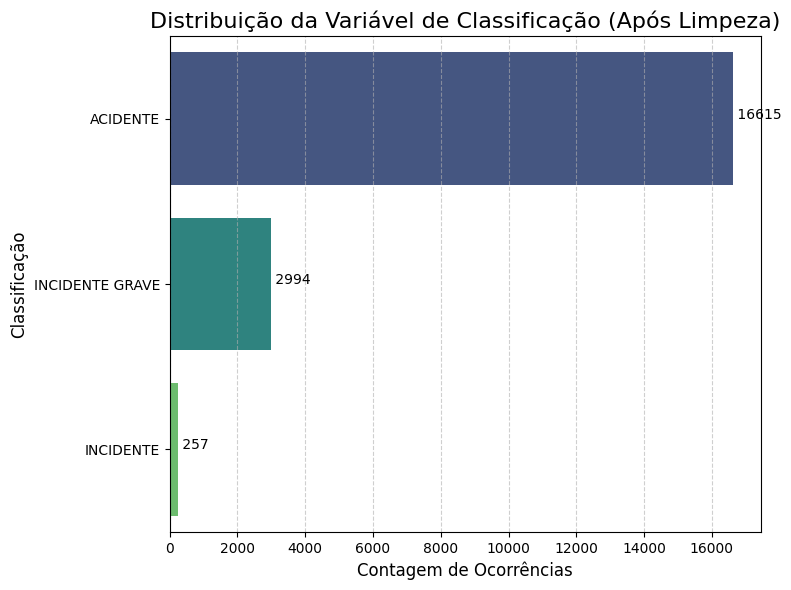

In [35]:
# Configurações
plt.figure(figsize=(8, 6))

# Gráfico de contagem
sns.countplot(
    data=df_consolidado,
    y='ocorrencia_classificacao',
    order=df_consolidado['ocorrencia_classificacao'].value_counts().index,
    palette='viridis',
    hue='ocorrencia_classificacao',
    legend=False
)

# Título e rótulos
plt.title('Distribuição da Variável de Classificação (Após Limpeza)', fontsize=16)
plt.xlabel('Contagem de Ocorrências', fontsize=12)
plt.ylabel('Classificação', fontsize=12)

for index, value in enumerate(df_consolidado['ocorrencia_classificacao'].value_counts()):
    plt.text(value, index, f' {value}')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

De acordo com o gráfico, podemos ver que o dataframe tem uma proporção muito maior de acidentes.

#**Análise Exploratória de Dados (EDA)**

Estudando alguns casos que utilizaram essa fonte de dados ou dados similares, verifiquei que é um caso de Classificação (e não Regressão), podendo treinar e comparar os modelos como** Random Forest**, **XGBoost** e **LightGBM**.

Com algumas pesquisas e com a consulta nos dados consolidados, escolhi o **XGBoost (Extreme Gradient Boosting)** como o modelo principal do projeto, pois o cenário é de classificação em um dataset com dados mistos e desbalanceados.

O F1-Score é utilizado após o treinamento, pois é a métrica de avaliação mais adequada, pois envolve um dataset desbalanceado e a necessidade de prever as três classes (ACIDENTE, INCIDENTE GRAVE, INCIDENTE).

##Treinando o modelo XGBoost

----------------------------------------------------------------------------------------------------
Iniciando o treinamento do modelo.
Aguarde o progresso...

----------------------------------------------------------------------------------------------------
[0]	validation_0-merror:0.03900
[50]	validation_0-merror:0.01208
[99]	validation_0-merror:0.00830
----------------------------------------------------------------------------------------------------
F1-Score do Modelo Final (com todos os dados): 0.99
----------------------------------------------------------------------------------------------------


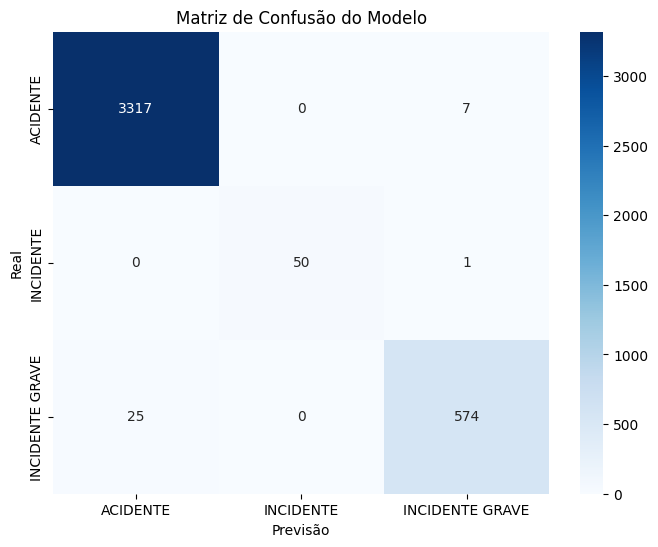

In [36]:
# Separando X e y
# A variavel 'y' e a classificacao da ocorrencia
y = df_consolidado['ocorrencia_classificacao']

# A variavel 'X' sao todas as outras colunas
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Codificando o 'y' (label encoding)
# A maioria dos modelos de ML exige labels numericos
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Codificando o 'X' (one-hot encoding) ---
# Transformar todas as variaveis categoricas em numericas
X_encoded = pd.get_dummies(X)

# Correção: Renomear as colunas para remover caracteres inválidos
X_encoded.columns = X_encoded.columns.str.replace('[', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(']', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('<', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('>', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('=', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(' ', '_', regex=False)

# Dividindo os dados em treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Treinando o modelo XGBoost com monitoramento
model_final = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='merror',
    # use_label_encoder=False,
    random_state=42
)

separadorLinha()
print("Iniciando o treinamento do modelo.\nAguarde o progresso...\n")
separadorLinha()

# Adicionando eval_set e verbose ao método .fit()
model_final.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)], # Conjunto de dados para avaliação
    verbose=50 # Imprimindo o resultado a cada 50 rodadas
)

# Previsão e Avaliação
y_pred_final = model_final.predict(X_test)
f1_final = f1_score(y_test, y_pred_final, average='weighted')

separadorLinha()
print(f"F1-Score do Modelo Final (com todos os dados): {f1_final:.2f}")
separadorLinha()

# Visualizando a Matriz de Confusao
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão do Modelo')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

O gráfico mostra o resultado do treinamento e podemos ver que o modelo ainda está sofrendo com o desbalanceamento das classes.  

A matriz de confusão (sem o balanceamento) mostra a seguinte performance das classes reais:

**ACIDENTE:** O modelo acerta quase todos os ACIDENTES (3317) e só erra 7, classificando-os como INCIDENTE GRAVE.
*  Previsão "ACIDENTE": 3317
*  Previsão "INCIDENTE": 0
*  Previsão "INCIDENTE GRAVE": 7

**INCIDENTE:** Razoável: O modelo acerta 50 dos casos reais de INCIDENTE e erra apenas 1, classificando-o como INCIDENTE GRAVE.  
*  Previsão "ACIDENTE": 0
*  Previsão "INCIDENTE": 50
*  Previsão "INCIDENTE GRAVE": 1

**INCIDENTE GRAVE:** Bom, mas com Erro, porque o modelo acerta 574 casos, mas classifica 25 casos reais de INCIDENTE GRAVE como ACIDENTE.
*  Previsão "ACIDENTE": 25
*  Previsão "INCIDENTE": 0
*  Previsão "INCIDENTE GRAVE": 574

###Salvando o modelo treinado

O treinamento é curto, em torno de 3 minutos, caso seja necessário o modelo, poderá carregar o modelo.

In [37]:
nome_arquivo_modelo = 'thomas_modelo_xgb.joblib'
joblib.dump(model_final, nome_arquivo_modelo)

separadorLinha()
print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo}")
print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo) / (1024*1024):.2f} MB")
separadorLinha()

----------------------------------------------------------------------------------------------------
Modelo salvo com sucesso como: thomas_modelo_xgb.joblib
Tamanho do arquivo: 1.02 MB
----------------------------------------------------------------------------------------------------


Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [48]:
# Isso abrirá uma janela no seu navegador para baixar o arquivo
## files.download(nome_arquivo_modelo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Teste do modelo treinado

Para testar o modelo, vamos listar os valores contidos em cada coluna do dataframe Consolidado

In [39]:
# Lista das colunas
colunas_para_analisar = [
    'aeronave_pmd_categoria',
    'aeronave_assentos',
    'aeronave_ano_fabricacao',
    'aeronave_motor_tipo',
    'aeronave_tipo_veiculo',
    'tem_fator_contribuinte',
    'tem_recomendacao',
    'aeronave_nivel_dano',
    'ocorrencia_uf',
    'ocorrencia_tipo_categoria',
    'ocorrencia_tipo'
]

for coluna in colunas_para_analisar:
    df_valores_ordenados = pd.DataFrame(df_consolidado[coluna].unique(), columns=[coluna])

    separadorLinha()
    print(f'{MSG_LISTA_VALORES_COLUNA} "{coluna}":')
    separadorLinha()
    print(df_valores_ordenados.sort_values(by=coluna).reset_index(drop=True))
    separadorLinha(True)


----------------------------------------------------------------------------------------------------
Lista de todos os valores da coluna "aeronave_pmd_categoria":
----------------------------------------------------------------------------------------------------
  aeronave_pmd_categoria
0                   LEVE
1                  MEDIO
2                 PESADO
3                  JUMBO
4           ULTRA PESADO
5         SEM INFORMACAO
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Lista de todos os valores da coluna "aeronave_assentos":
----------------------------------------------------------------------------------------------------
    aeronave_assentos
0                 0.0
1                 1.0
2                 2.0
3                 3.0
4                 4.0
5                 5.0
6                 6.0
7                 7.0
8

###Criando dois cenários para previsão

In [40]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL',
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

df_teste_modelo_teste02 = pd.DataFrame([{
    # FATOR MAIS IMPORTANTE: dano nenhum, que indica um evento menos grave
    'aeronave_nivel_dano': 'NENHUM',

    # OUTRAS FEATURES QUE INDICAM BAIXA GRAVIDADE
    'aeronave_pmd': 600, # PMD leve
    'aeronave_assentos': 4, # Aeronave muito pequena
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])


Testando o modelo com df_teste_modelo_teste01 e df_teste_modelo_teste02

In [41]:
# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste01)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_final.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste02)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_final.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 02 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

Teste 01 A previsão para o novo dado é: ACIDENTE
Teste 02 A previsão para o novo dado é: INCIDENTE GRAVE


Conforme a análise da Matriz de Confusão do Modelo e o teste dos cenários os resultados foram do tipo **ACIDENTE** ou **INCIDENTE GRAVE**.  
Não consegui testar com parâmetros que possam gerar a previsão **INCIDENTE**, e podemos concluir que o modelo possa estar enviesado e uma forte tendência a prever ACIDENTE, por ser a classe mais comum no seu conjunto de dados de treino.

##Verificando as features mais importantes

Na tentativa de conseguir um resultado do tipo **INCIDENTE**, vamos "pedir" ao modelo que liste as features mais importantes que ele usa para tomar suas decisões.

----------------------------------------------------------------------------------------------------
As 15 features mais importantes para o modelo são:
----------------------------------------------------------------------------------------------------
                                              feature  importance
12231                      aeronave_nivel_dano_NENHUM    0.073439
12230                        aeronave_nivel_dano_LEVE    0.068738
4495                          ocorrencia_cidade_NATAL    0.043188
4688                     ocorrencia_cidade_SANTA_INÊS    0.032012
12286                          ocorrencia_tipo_OUTROS    0.027694
5                          aeronave_fatalidades_total    0.021572
5574                        ocorrencia_dia_04/09/2013    0.017325
1811                ocorrencia_latitude_-8.9494444444    0.013902
7022                        ocorrencia_dia_26/08/2011    0.013843
12243  ocorrencia_tipo_COLISÃO_COM_OBSTÁCULOS_NO_SOLO    0.012739
10125                

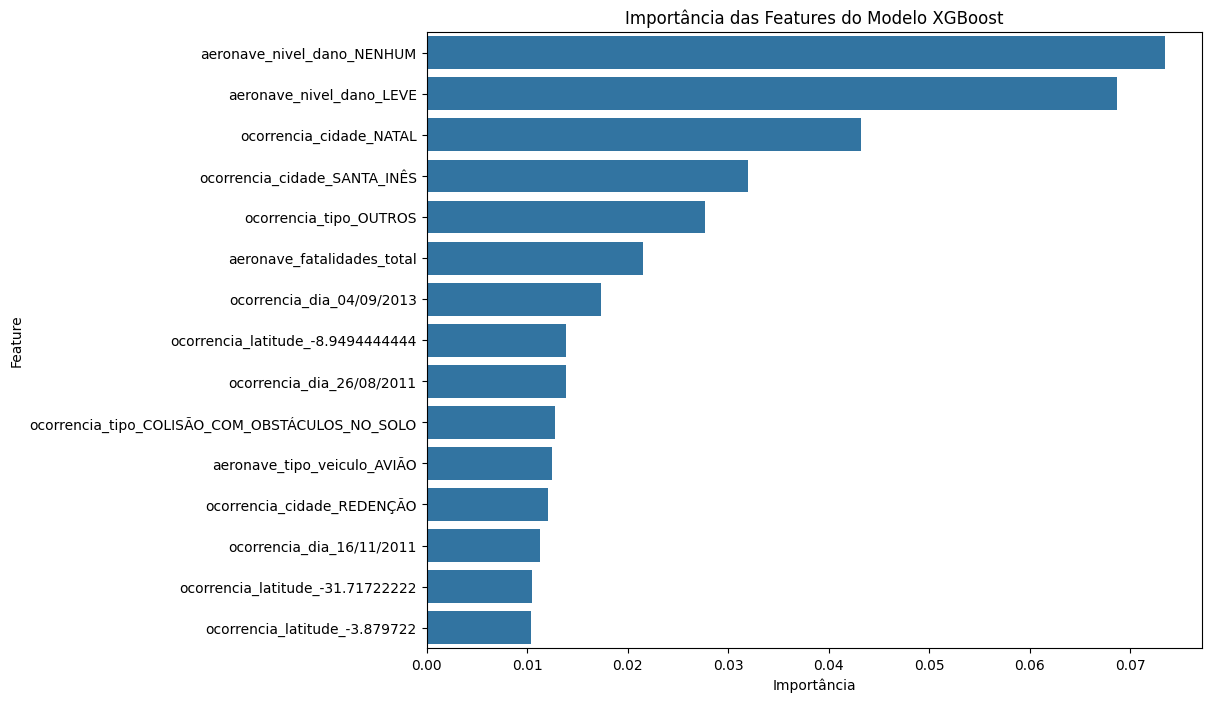

In [42]:
# Obter a importância das features a partir do modelo treinado
importances = model_final.feature_importances_

# Criar um DataFrame com a importancia de cada feature
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Ordenar o dataFrame de acordo com as features mais importantes
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Listar as 15 features mais importantes
separadorLinha()
print("As 15 features mais importantes para o modelo são:")
separadorLinha()
print(feature_importance_df.head(15))

# Gerar gráfico de barras com o resultado
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Importância das Features do Modelo XGBoost')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

O gráfico lista as 15 colunas que o modelo XGBoost usou para a tomada de decisões.  

*  O principal fator é o dano na aeronave, pois a feature **aeronave_nivel_dano** se destaca com maior grau de importância no modelo. Condizente com o contexto dos datasets, pois o nível de dano em um avião é um indicador da gravidade de uma ocorrência.
*  Para classificar ocorrências de menor gravidade, o modelo está usando a ausência de dano **aeronave_nivel_dano_NENHUM** e um dano leve **aeronave_nivel_dano_LEVE**.
*  Verificamos que a feature **aeronave_nivel_dano_DESTRUIDA** é uma feature-chave, e pode estar empurrando as previsões para ACIDENTE.

Como **observação** verificamos que ele considera as features de número de fatalidades **aeronave_fatalidades_total** e a cidade onde a ocorrência aconteceu nas previsões.


##Treinando o modelo XGBoost com os dados balanceados (SMOTE)

Vimos na análise do treinamento que temos uma **distribuição desbalanceada das classes**.  
Por isso, vou aplicar a técnica de balanceamento de dados e optei por usar o **SMOTE** (Synthetic Minority Over-sampling Technique), pois ele cria novos exemplos sintéticos da classe minoritária (INCIDENTE) e acredito que vai igualar o número de exemplos com a classe majoritária.

**Observação:** Devido à limitação na memória RAM deste notebook, vou reutilizar as variaveis do treinamento anterior e salvar um arquivo com este treinamento separado.

In [43]:
# Separando X e y
y = df_consolidado['ocorrencia_classificacao']
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Label enconding para codificar o y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot-enconding para codificar o X
X_encoded = pd.get_dummies(X)

# Renomear as colunas para remover caracteres inválidos
X_encoded.columns = X_encoded.columns.str.replace('[', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(']', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('<', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('>', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('=', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(' ', '_', regex=False)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Aplicando o SMOTE nos dados de treino
print("Distribuição das classes no conjunto de treino antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes no conjunto de treino APÓS o SMOTE:")
print(Counter(y_train_resampled))

# Treinando o modelo XGBoost com os dados balanceados
model_smote = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='merror',
    # use_label_encoder=False,
    random_state=42
)

separadorLinha()
print("\nTreinando o modelo com o dataset balanceado...")
separadorLinha(True)
model_smote.fit(X_train_resampled, y_train_resampled)

# --- 7. Testar a predição para "INCIDENTE" com o novo modelo ---
novo_dado = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(novo_dado)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train_resampled.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_smote.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"\nA previsão para o novo dado com o modelo SMOTE é: {predicao_legivel[0]}")

Distribuição das classes no conjunto de treino antes do SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 2395, np.int64(1): 206})

Distribuição das classes no conjunto de treino APÓS o SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 13291, np.int64(1): 13291})
----------------------------------------------------------------------------------------------------

Treinando o modelo com o dataset balanceado...
----------------------------------------------------------------------------------------------------



A previsão para o novo dado com o modelo SMOTE é: INCIDENTE GRAVE


###Salvando o modelo treinado

O treinamento é curto, em torno de 3 minutos, caso seja necessário o modelo, poderá carregar o modelo.

In [44]:
nome_arquivo_modelo_smote = 'thomas_modelo_xgb_smote.joblib'
joblib.dump(model_smote, nome_arquivo_modelo_smote)

separadorLinha()
print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo_smote}")
print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo_smote) / (1024*1024):.2f} MB")
separadorLinha()

----------------------------------------------------------------------------------------------------
Modelo salvo com sucesso como: thomas_modelo_xgb_smote.joblib
Tamanho do arquivo: 1.03 MB
----------------------------------------------------------------------------------------------------


Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [50]:
# Isso abrirá uma janela no seu navegador para baixar o arquivo
# files.download(nome_arquivo_modelo_smote)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Teste do modelo treinado

In [46]:
# Crie um novo exemplo de dado em um DataFrame
# Preencha com caracteristicas que o modelo associa a um INCIDENTE
novo_dado = pd.DataFrame([{
    # FATOR MAIS IMPORTANTE: dano nenhum, que indica um evento menos grave
    'aeronave_nivel_dano': 'NENHUM',

    # OUTRAS FEATURES QUE INDICAM BAIXA GRAVIDADE
    'aeronave_pmd': 600, # PMD leve
    'aeronave_assentos': 4, # Aeronave muito pequena
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplique o mesmo One-Hot Encoding nos novos dados
novo_dado_encoded = pd.get_dummies(novo_dado)

# Garanta que as colunas do novo dado estejam na mesma ordem das colunas de treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)

# Faça a previsão usando o NOVO MODELO TREINADO COM SMOTE
predicao_numerica = model_smote.predict(novo_dado_encoded)

# Converta o resultado numérico de volta para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"A previsão para o novo dado com o modelo SMOTE é: {predicao_legivel[0]}")

A previsão para o novo dado com o modelo SMOTE é: INCIDENTE GRAVE


Gerando Matriz de Confusão com o modelo após SMOTE

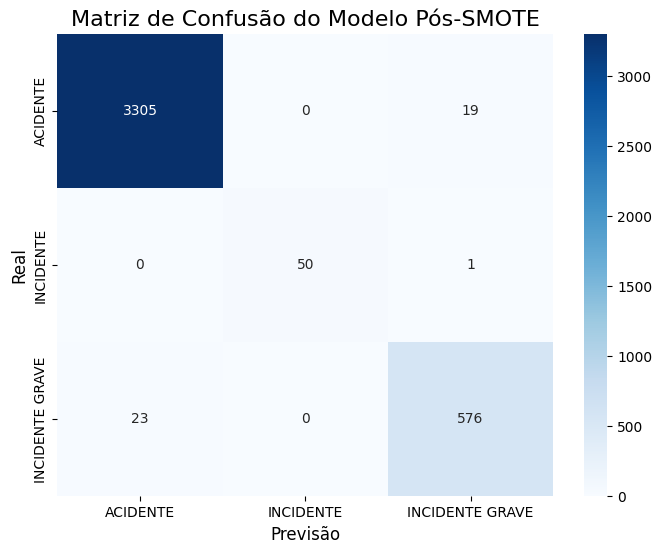

F1-Score do Modelo Pós-SMOTE (weighted): 0.9892


In [47]:
y_pred_smote = model_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm_smote,
    annot=True,
    fmt='d', # 'd' para formatar como inteiro
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusão do Modelo Pós-SMOTE', fontsize=16)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

from sklearn.metrics import f1_score
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
print(f"F1-Score do Modelo Pós-SMOTE (weighted): {f1_smote:.4f}")

Comparando a matriz de confusão antes e depois do SMOTE, podemos ver que a qualidade da diferenciação do modelo melhorou, especialmente nas classes mais críticas.

**Classe ACIDENTE**
*  Real Pré-SMOTE: 3317
*  Real Pós-SMOTE: 3305
*  Estável: A precisão na classe mais importante (segurança) permanece altíssima, com uma leve variação de 12 acertos (a menos).

**Classe INCIDENTE**
*  Real Pré-SMOTE: 50
*  Real Pós-SMOTE: 50
*  Estável: O número de acertos se manteve, mostrando que o modelo já tinha um bom entendimento dessa classe.

**Classe INCIDENTE GRAVE**
*  Real Pré-SMOTE (Acertos): 574
*  Real Pós-SMOTE (Acertos): 576
*  Melhoria: O modelo pós-SMOTE acertou 2 casos a mais de INCIDENTE GRAVE, mostrando maior capacidade de identificação dessa classe.

O modelo Pré-SMOTE errava 25 vezes ao classificar um INCIDENTE GRAVE como ACIDENTE. Com o balanceamento, o modelo Pós-SMOTE reduziu esse erro para apenas 23 casos, tornando o nosso sistema de alerta mais seguro e confiável.

#**Conclusão**

O fato do modelo ainda estar prevendo INCIDENTE GRAVE mostra que alcançamos um ponto crítico de sucesso ao encontrar uma limitação, apesar de conseguir sair de um modelo que não conseguia prever nada além de "ACIDENTE" para um modelo que acerta a grande maioria dos casos de INCIDENTE GRAVE.  
<br>
**Por Que a Previsão "INCIDENTE" não Funcionou?**  
Fui atrás das possibilidades de ainda não ter uma previsão de "INCIDENTE" e se é uma limitação da sua base de dados e não um erro no processo.

A classe "INCIDENTE" é extremamente rara, pois as características que a definem são muito parecidas com as de um "INCIDENTE GRAVE".

O modelo aprendeu a separar ACIDENTE de todas as outras classes, mas, na dúvida, ele classifica as ocorrências de menor gravidade como a classe que possui mais exemplos, que é INCIDENTE GRAVE.

Acredito que neste cenário, haveria que se avaliar algumas características muito particulares para a classe INCIDENTE.